In [12]:
import re
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import json
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk

In [13]:
def chunk_sentence(sentence, max_words=15):
    words = sentence.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunk = words[i:i+max_words]
        chunks.append(' '.join(chunk))
    return chunks

In [14]:
bk1 = open('book1.txt', 'r', encoding='utf-8').read().replace('\n', ' ').split('.')
bk1[1:3]

['  Everything was in confusion in the Oblonskys’ house',
 ' The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on living in the same house with him']

In [15]:
bk2 = open('book2.txt', 'r', encoding='utf-8').read().replace('\n', ' ').split('.')
bk2[1:3]

[' It stands in the centre of a small bay, and upon a gentle acclivity, which, on one side, slopes towards the sea, and on the other rises into an eminence crowned by dark woods',
 ' The situation is admirably beautiful and picturesque, and the ruins have an air of ancient grandeur, which, contrasted with the present solitude of the scene, impresses the traveller with awe and curiosity']

In [16]:
raw_sentences = bk1 + bk2
sentences = []
max_words = 30
for sentence in raw_sentences:
    chunks = chunk_sentence(sentence, max_words=max_words)
    for c in chunks:
        if len(c) > 2:
            sentences.append(c)

In [17]:
sentences[:2]

['PART ONE Chapter 1 Happy families are all alike; every unhappy family is unhappy in its own way',
 'Everything was in confusion in the Oblonskys’ house']

In [18]:
len(sentences)

10627

In [19]:
def clean_text(text):
    text = text.lower()
    # Add spaces around punctuation
    text = re.sub(r'([^\w\s])', r' \1 ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


def get_only_words(text):
    tokens = word_tokenize(text)
    words = [token for token in tokens if token.isalpha()]
    return words

In [20]:
sentences = [clean_text(txt) for txt in sentences]
len(sentences)

10627

In [21]:
sentences[1:3]

['everything was in confusion in the oblonskys house',
 'the wife had discovered that the husband was carrying on an intrigue with a french girl who had been a governess in their family and she had announced to her']

In [22]:
word_list1 = set(get_only_words("".join(bk2)))
word_list2 = set(get_only_words("".join(bk1)))
all_word_list = list(word_list1) + list(word_list2)
all_word_list[:3]

['thrilled', 'conquered', 'determined']

In [23]:
w_to_i = {word:i+2 for i, word in enumerate(set(all_word_list))}
w_to_i['<UNK>'] = 1
i_to_w = {v:k for k, v in w_to_i.items()}
with open('vocab.json', 'w') as fp:
    json.dump(w_to_i, fp)

In [24]:
vocab_size = len(set(w_to_i.values())) +1 #+1 for padding "0"
vocab_size

11130

In [25]:
def sentence_to_int(sentence):
    sentence_to_int = []
    for word in sentence.split(" "):
        int_word = w_to_i.get(word, w_to_i.get('<UNK>'))
        sentence_to_int.append(int_word)
    return sentence_to_int

In [26]:
sentence_to_int('everything was in confusion in the oblonskys house')

[5252, 7624, 5930, 3840, 5930, 10583, 1, 2659]

In [27]:
int_sentences = [sentence_to_int(sentence) for sentence in sentences]
int_sentences[1]

[5252, 7624, 5930, 3840, 5930, 10583, 1, 2659]

In [28]:
len(int_sentences)

10627

In [29]:
max(len(x) for x in int_sentences)

36

In [30]:
input_sq = []
output_sq = []
for sentence in int_sentences:
    for i in range(1, len(sentence)):
        temp = sentence[:i]
        pad = ( max_words - len(temp), 0)
        if temp != None:
            try:
                padded = F.pad(torch.tensor(temp), pad, value= 0)
            except Exception as e:
                print(e)
                print(sentence)
                print(temp)
                break

            input_sq.append(padded)
            output_sq.append(sentence[i])

In [31]:
len(input_sq)

175640

In [32]:
len(output_sq)

175640

In [33]:
class mydata(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [34]:
torch.manual_seed(10)
data = mydata(input_sq, torch.tensor(output_sq))
batched_data= DataLoader(data, 64, shuffle=True)

In [35]:
class Normal_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim=100, padding_idx = 0)
        self.do = nn.Dropout(.1)
        self.lstm = nn.LSTM(input_size = 100, hidden_size=150, num_layers=2, batch_first = True)
        self.layers = nn.Sequential(
            nn.Linear(in_features=150, out_features=200),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=vocab_size)
        )
    def forward(self, x):
        x = self.emb(x)
        y = self.do(x)
        h, c = self.lstm(x)
        y = h[:, -1, :]
        y = self.layers(y)

        return y

In [36]:
class Bi_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim=100, padding_idx = 0)
        self.do = nn.Dropout(.1)
        self.lstm = nn.LSTM(input_size = 100, hidden_size=150, num_layers=2, batch_first = True, bidirectional=True)
        self.layers = nn.Sequential(
            nn.Linear(in_features=150*2, out_features=200),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=vocab_size)
        )
    def forward(self, x):
        x = self.emb(x)
        y = self.do(x)
        h, c = self.lstm(x)
        y = h[:, -1, :]
        y = self.layers(y)

        return y

In [48]:
class bi_GRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim=100, padding_idx = 0)
        self.do = nn.Dropout(.1)
        self.gru = nn.GRU(input_size = 100, hidden_size=150, num_layers=2, batch_first = True, bidirectional=True)
        self.layers = nn.Sequential(
            nn.Linear(in_features=2*150, out_features=200),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=vocab_size)
        )
    def forward(self, x):
        x = self.emb(x)
        y = self.do(x)
        h, c = self.gru(x)
        y = h[:, -1, :]
        y = self.layers(y)

        return y

In [39]:
def train(model, epochs, optim, loss_fn, file_name, patient = 3):
    model.train()
    best_loss = float('inf')
    epochs_loss = []
    for epoch in range(epochs):
        loss_ = []
        for batch in batched_data:
            x, y = batch
            x, y  = (x).to(device), (y).to(device)
            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            optim.zero_grad()

            loss_.append(loss.item())

        epoch_loss = np.mean(loss_)
        epochs_loss.append(epoch_loss)
        print(f"Epochs: {epoch} | Loss: {epoch_loss:.4f}")

        if best_loss > epoch_loss:
            best_loss = epoch_loss
            counter = 0
            torch.save(model.state_dict(), f"models/{file_name}_best_model.pt")
            print(f"model saved with loss: {best_loss:.4f}")
        else:
            counter += 1
            if counter >= patient:
                print(f"Early stopping after {epoch} epochs without improvement")
                break

    return epochs_loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_lstm = (Normal_LSTM()).to(device)
model_bilstm= (Bi_LSTM()).to(device)

all_loss = {}
for name, model in zip(['LSTM', 'BiLSTM'], [model_lstm, model_bilstm]):
    print(f"Training {name} model")
    optim = Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0) #ignoring padding
    loss = train(model, 20, optim, loss_fn, file_name = name)
    all_loss[name] = loss

Using device: cuda
Training LSTM model
Epochs: 0 | Loss: 6.2407
model saved with loss: 6.2407
Epochs: 1 | Loss: 5.6369
model saved with loss: 5.6369
Epochs: 2 | Loss: 5.3301
model saved with loss: 5.3301
Epochs: 3 | Loss: 5.0965
model saved with loss: 5.0965
Epochs: 4 | Loss: 4.8865
model saved with loss: 4.8865
Epochs: 5 | Loss: 4.6898
model saved with loss: 4.6898
Epochs: 6 | Loss: 4.5110
model saved with loss: 4.5110
Epochs: 7 | Loss: 4.3379
model saved with loss: 4.3379
Epochs: 8 | Loss: 4.1774
model saved with loss: 4.1774
Epochs: 9 | Loss: 4.0252
model saved with loss: 4.0252
Epochs: 10 | Loss: 3.8868
model saved with loss: 3.8868
Epochs: 11 | Loss: 3.7545
model saved with loss: 3.7545
Epochs: 12 | Loss: 3.6331
model saved with loss: 3.6331
Epochs: 13 | Loss: 3.5118
model saved with loss: 3.5118
Epochs: 14 | Loss: 3.4033
model saved with loss: 3.4033
Epochs: 15 | Loss: 3.2992
model saved with loss: 3.2992
Epochs: 16 | Loss: 3.2010
model saved with loss: 3.2010
Epochs: 17 | Loss: 

AttributeError: 'bi_GRU' object has no attribute 'lstm'

In [49]:
model_bigru = (bi_GRU()).to(device)

print(f"Training BiGRU model")
optim = Adam(model_bigru.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=0) #ignoring padding
loss = train(model_bigru, 20, optim, loss_fn, file_name = 'BiGRU')
all_loss['BiGRU'] = loss

Training BiGRU model
Epochs: 0 | Loss: 6.0874
model saved with loss: 6.0874
Epochs: 1 | Loss: 5.5199
model saved with loss: 5.5199
Epochs: 2 | Loss: 5.2211
model saved with loss: 5.2211
Epochs: 3 | Loss: 4.9766
model saved with loss: 4.9766
Epochs: 4 | Loss: 4.7618
model saved with loss: 4.7618
Epochs: 5 | Loss: 4.5724
model saved with loss: 4.5724
Epochs: 6 | Loss: 4.3969
model saved with loss: 4.3969
Epochs: 7 | Loss: 4.2415
model saved with loss: 4.2415
Epochs: 8 | Loss: 4.1025
model saved with loss: 4.1025
Epochs: 9 | Loss: 3.9756
model saved with loss: 3.9756
Epochs: 10 | Loss: 3.8642
model saved with loss: 3.8642
Epochs: 11 | Loss: 3.7663
model saved with loss: 3.7663
Epochs: 12 | Loss: 3.6791
model saved with loss: 3.6791
Epochs: 13 | Loss: 3.5997
model saved with loss: 3.5997
Epochs: 14 | Loss: 3.5294
model saved with loss: 3.5294
Epochs: 15 | Loss: 3.4591
model saved with loss: 3.4591
Epochs: 16 | Loss: 3.4116
model saved with loss: 3.4116
Epochs: 17 | Loss: 3.3583
model saved

Text(0.5, 0, 'Epochs')

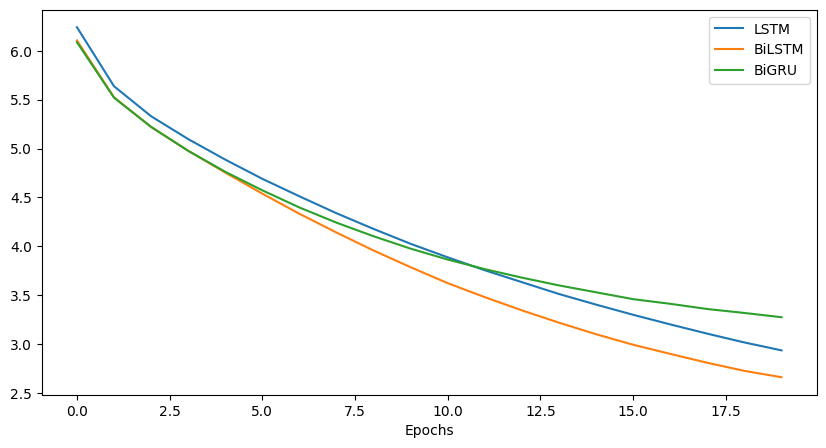

In [51]:
plt.figure(figsize=(10, 5))
for name, loss in all_loss.items():
    plt.plot(loss, label=name)
    plt.legend()
plt.xlabel('Epochs')    

In [52]:
x = 'can I go'

for j in range(20):
  with torch.no_grad():
    x_int = [w_to_i.get(i, 1) for i in x.lower().split()]
    x_tensor = torch.tensor(x_int).to(device)
    x_tensor = x_tensor.unsqueeze(0)
    y = model_bilstm(x_tensor)
    y = i_to_w.get(torch.argmax(y).item())
    x = x + ' ' + y
    print(x)

can I go into
can I go into the
can I go into the <UNK>
can I go into the <UNK> <UNK>
can I go into the <UNK> <UNK> board
can I go into the <UNK> <UNK> board with
can I go into the <UNK> <UNK> board with a
can I go into the <UNK> <UNK> board with a scrutinizing
can I go into the <UNK> <UNK> board with a scrutinizing eye
can I go into the <UNK> <UNK> board with a scrutinizing eye and
can I go into the <UNK> <UNK> board with a scrutinizing eye and suggested
can I go into the <UNK> <UNK> board with a scrutinizing eye and suggested with
can I go into the <UNK> <UNK> board with a scrutinizing eye and suggested with a
can I go into the <UNK> <UNK> board with a scrutinizing eye and suggested with a salt
can I go into the <UNK> <UNK> board with a scrutinizing eye and suggested with a salt soft
can I go into the <UNK> <UNK> board with a scrutinizing eye and suggested with a salt soft gleam
can I go into the <UNK> <UNK> board with a scrutinizing eye and suggested with a salt soft gleam of
can I 